# flame stability
# author: juanjocv@gmail.com

In [1]:
%matplotlib widget

import numpy as np
#import scipy.io
#import math
import matplotlib.pyplot as plt
import tifffile as tiff         # Loads tiff files as numpy arrays
import cv2
import os

#import matplotlib.cm as cm 
#import scipy.optimize as so
from scipy.signal import savgol_filter
from scipy import signal
# Import Module

#import pandas as pd
#import openpyxl

## load sif reader image https://github.com/fujiisoup/sif_reader
# import sif_reader

# Functions

In [2]:
def define_circle(p1, p2, p3):
    """
    Returns the center and radius of the circle passing the given 3 points.
    In case the 3 points form a line, returns (None, infinity).
    """
    temp = p2[0] * p2[0] + p2[1] * p2[1]
    bc = (p1[0] * p1[0] + p1[1] * p1[1] - temp) / 2
    cd = (temp - p3[0] * p3[0] - p3[1] * p3[1]) / 2
    det = (p1[0] - p2[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p2[1])

    if abs(det) < 1.0e-6:
        return (None, np.inf)

    # Center of circle
    cx = (bc*(p2[1] - p3[1]) - cd*(p1[1] - p2[1])) / det
    cy = ((p1[0] - p2[0]) * cd - (p2[0] - p3[0]) * bc) / det

    center = np.array([cx,cy])
    radius = np.sqrt((cx - p1[0])**2 + (cy - p1[1])**2)
    return (center, radius)

# https://www.pyimagesearch.com/2021/01/19/image-masking-with-opencv/



# Variables

In [3]:
save_data = 1
ifig = 1
f_aspect = 1
casos = 9 # numero de casos

m_fuel = np.arange(150,240,10)
print(m_fuel)

folder_daq = r'/mnt/shared/Linux/Smoke_point_Butano_corriente/DAQ/ASCII'
data_scale = r'/mnt/shared/Linux/Smoke_point_Butano_corriente/Basler/scale/Basler_acA1920-150um__40030267__20220120_164658621_0000.tiff'
folder_flame = r'/mnt/shared/Linux/Smoke_point_Butano_corriente/Basler/caso_9'

[150 160 170 180 190 200 210 220 230]


# Load photodiode data

In [33]:
# Folder Path
path = folder_daq
# Change the directory
os.chdir(path)
# Read text File

# iterate through all file
dct_1 = {}
con1 = -1

for file in os.listdir():
    # Check whether file is in text format or not
    if file.startswith('caso'): # and file.endswith('00.txt'):         
        file_path = f"{path}/{file}"
        dct_1['file_%s' % (con1+1)] = [file]  
        con1 = con1 + 1
        textlines1 = np.loadtxt(file_path, delimiter='\t', skiprows=2, usecols = (1,2), dtype=str)
        
        if con1 < 1:
        # call read text file function
            a, b = np.shape(textlines1)
            print("a: {}, b: {}".format(a,b))
            t_raw = np.zeros((a,casos))
            print("Forma de arreglo t_raw (temporal para caso): {}".format(np.shape(t_raw)))
            V_raw = np.zeros_like(t_raw)
            t_raw[:,con1] = textlines1[:,0]
            # Al solo usar el campo de ms se pierde informacion cuando se superan los 999 ms // Aumentan los segundos
            print("249x0: {}".format(t_raw[249,0]))
            print("250x0: {}".format(t_raw[250,0]))
            print("251x0: {}".format(t_raw[251,0]))
            #t_raw[:,con1] = textlines1[:,0].astype(np.float)
            V_raw[:,con1] = np.char.replace(textlines1[:,1], ',', '.')
        if con1 > 0:
            #t_raw[:,con1] = textlines1[:,0].astype(np.float)
            t_raw[:,con1] = textlines1[:,0]
            V_raw[:,con1] = np.char.replace(textlines1[:,1], ',', '.')
    ####
dt = 0.001*(t_raw[1,0]-t_raw[0,0])
ti = np.arange(a)*dt
print(ti)

Fs = 1/dt

t0 = 0      # Initial time
tf = 10   # Final time
rang = Fs*np.array([t0,tf])
rang = rang.astype(int)

time = ti[rang[0]:rang[1]]
Ls = len(time)     #Tamaño de la señal 
Sc = np.zeros((Ls,casos))
FFT_s = np.zeros((int(Ls/2+1),casos))

for ii in range(casos):
    Sc[:,ii] = V_raw[rang[0]:rang[1],ii]    # Signal
    

    Sc[:,ii] = Sc[:,ii] - np.mean(Sc[:,ii])
    FFT_s[:,ii] = abs(np.fft.rfft(Sc[:,ii])) / Ls
    freq = np.linspace(0,Fs/2,len(FFT_s[:,ii]))

    #f, Pxx_den = signal.periodogram(Sc[:,ii], Fs)

V_mean = np.mean(V_raw, axis=0)

a: 25000, b: 2
Forma de arreglo t_raw (temporal para caso): (25000, 9)
249x0: 996.0
250x0: 0.0
251x0: 4.0
[    0     1     2 ... 24997 24998 24999]
[0.0000e+00 4.0000e-03 8.0000e-03 ... 9.9988e+01 9.9992e+01 9.9996e+01]


# FFT

/tmp/ipykernel_8321/2499933294.py:53: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax3.set_ylim(0,10)


Text(0, 0.5, '$Linear~spectrum [V RMS]$')

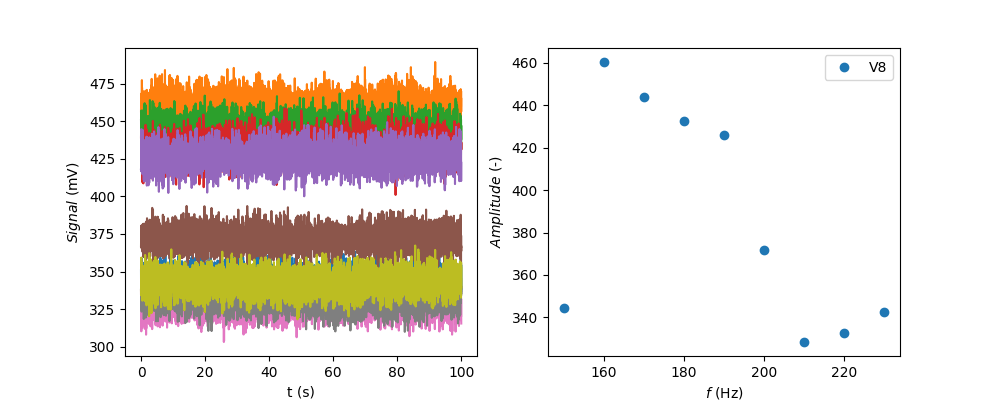

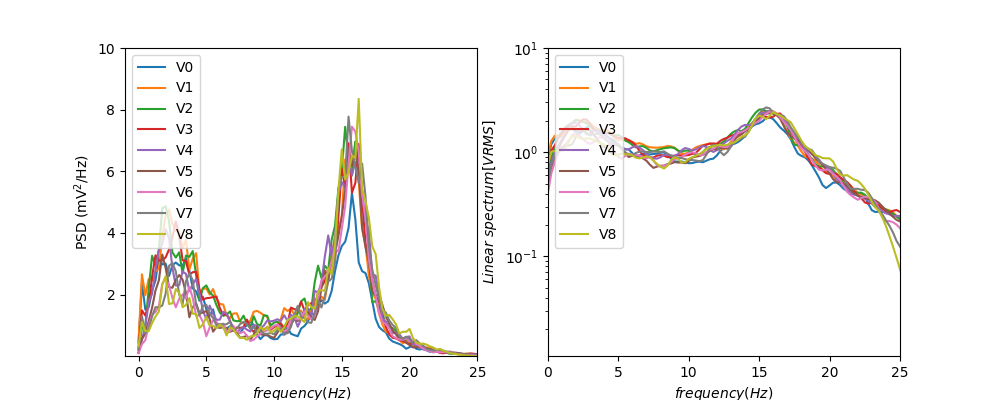

In [46]:
n_lenght = 1000

Pvv_den = []
Pvv_spec = []
#Sc = np.zeros((Ls,casos))
for ii in range(casos):
    frequency, Pv_den = signal.welch(V_raw[:,ii], Fs, nperseg=n_lenght)
    frequency, Pv_spec = signal.welch(V_raw[:,ii], Fs, 'flattop', nperseg=n_lenght, scaling='spectrum')
    Pvv_den.append(Pv_den)
    Pvv_spec.append(Pv_spec)
Pvv_den = np.array(Pvv_den).T
Pvv_spec = np.array(Pvv_spec).T


## figures
fig, (ax1,ax3) = plt.subplots(1,2, figsize=(10,4))      
for ii in range(int(casos)):
    ax1.plot(ti,V_raw[:,ii], label='V' + str(ii))
#ax1.legend(loc='upper left')
#ax1.set_title(str(lamb[0])+'nm')
ax1.set_xlabel('t (s)')
ax1.set_ylabel('$Signal$ (mV)')
#ax1.set_ylim(0,0.02)
#
ax3.plot(m_fuel, V_mean, 'o', label='V' + str(ii))
ax3.legend(loc='upper right')
#ax1.set_title(str(lamb[0])+'nm')
ax3.set_xlabel('$f$ (Hz)')
ax3.set_ylabel('$Amplitude$ (-)')
#ax3.set_xlim(-1,25)
#I_avg = np.mean(V_raw)

## figures
fig, (ax2,ax3) = plt.subplots(1,2, figsize=(10,4)) 
for ii in range(int(casos)):
    ax2.plot(frequency, Pvv_den[:,ii], label='V' + str(ii))
#ax2.plot(frequency, Pvv_den[:,8], label='V' + str(ii))
ax2.legend(loc='upper left')
#ax1.set_title(str(lamb[0])+'nm')
ax2.set_xlabel('$f$ (Hz)')
ax2.set_xlim(-1,25)
ax2.set_ylim(0.01,10)
ax2.set_xlabel(r'$frequency (Hz)$')
ax2.set_ylabel(r'PSD (mV$^2$/Hz)')

for ii in range(int(casos)):
    ax3.semilogy(frequency, np.sqrt(Pvv_spec[:,ii]), label='V' + str(ii))
#ax2.plot(frequency, Pvv_den[:,8], label='V' + str(ii))
ax3.legend(loc='upper left')
#ax1.set_title(str(lamb[0])+'nm')
ax3.set_xlabel('$f$ (Hz)')
ax3.set_xlim(0,25)
ax3.set_ylim(0,10)
ax3.set_xlabel(r'$frequency (Hz)$')
plt.ylabel(r'$Linear~spectrum [V RMS]$')

# Scale image and mask

[1450.97735618  215.58200734]


<function matplotlib.pyplot.show(close=None, block=None)>

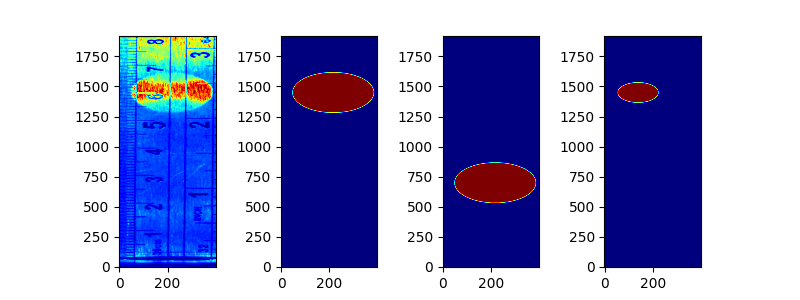

In [40]:
# load image
So = tiff.imread(data_scale)[:,:].astype(float) 
#S = cv2.resize(So ,None, fx = binx, fy = biny, interpolation = cv2.INTER_LINEAR)
img_sca = So.T
Nz, Nx = np.shape(img_sca)

""" fig, axs = plt.subplots(1,1, sharex=True, sharey=True, figsize=(3,3))    
im = axs.imshow(img_sca, vmin = 0, vmax= np.max(img_sca),  cmap='jet', aspect=0.5*f_aspect)
fig.colorbar(im, ax=axs)
axs.invert_yaxis()
plt.show """

# scale image m/px
dr = abs(7-1)*1e-2 / np.sqrt((72-64)**2 + (1976-302)**2)
# center
center, radius = define_circle([1480, 50 ], [1283, 209 ], [1524, 367 ])
print(center)
# mask:
#So = tiff.imread(data_scale)[:,:].astype(float) 
mask = np.zeros_like(So)
cv2.circle(mask, (int(center[0]),int(center[1])), int(radius), 2**16, -1)
mask = mask.T > 0 

mask2 = np.zeros_like(So)
cv2.circle(mask2, (int(center[0]-750),int(center[1])), int(radius), 2**16, -1)
mask2 = mask2.T > 0 

mask3 = np.zeros_like(So)
cv2.circle(mask3, (int(center[0]),int(center[1]-75)), int(radius/2), 2**16, -1)
mask3 = mask3.T > 0 

fig, (ax0,ax1,ax2,ax3) = plt.subplots(1,4, figsize=(8,3))    
im = ax0.imshow(img_sca, vmin = 0, vmax= np.max(img_sca),  cmap='jet', aspect=0.5*f_aspect)
#fig.colorbar(im, ax=ax0)
ax0.invert_yaxis()
#
im = ax1.imshow(mask, vmin = 0,  cmap='jet', aspect=0.5*f_aspect)
ax1.invert_yaxis()
plt.show
#   
im = ax2.imshow(mask2, vmin = 0,  cmap='jet', aspect=0.5*f_aspect)
ax2.invert_yaxis()
plt.show
#
im = ax3.imshow(mask3, vmin = 0,  cmap='jet', aspect=0.5*f_aspect)
ax3.invert_yaxis()
plt.show



# flame images

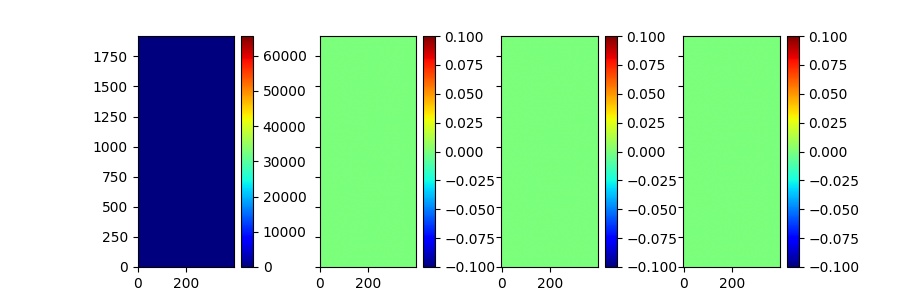

In [44]:
#So = tiff.imread(data_scale)[:,:].astype(float) 

n_img = 2500

# Folder Path
path = folder_flame
# Change the directory
os.chdir(path)
# Read text File

import glob
save_data = 0

filelist = glob.glob(path + '\*.tiff')
# print(filelist[1])

# iterate through all file
dct_1 = {}
con1 = -1

#x = np.array([ np.array(tiff.imread(fname)[:,:].astype(float)) for fname in filelist ])
images = np.zeros((Nz,Nx,n_img))
int_flame = np.zeros(n_img)
int_crop = np.zeros_like(int_flame)
int_crop2 = np.zeros_like(int_flame)
int_crop3 = np.zeros_like(int_flame)
if save_data == 1:
    img_mean = np.zeros_like(img_sca)
    img_std = np.zeros_like(img_sca)
    cont = -1
    n = 0
    for fname in filelist:
        cont = cont + 1
        #print(cont)
        aux = tiff.imread(fname)[:,:].astype(float)
        aux = aux.T
        int_flame[cont] = np.mean(aux)
        int_crop[cont] = np.mean(aux*mask)
        int_crop2[cont] = np.mean(aux*mask2)
        int_crop3[cont] = np.mean(aux*mask3)
        #images[:,:,cont] = aux
        n = n + 1
        m_prev = img_mean
        img_mean = img_mean + (aux - img_mean) / n 
        img_std = img_std + (aux - img_mean)*(aux - m_prev)
    img_std = np.sqrt(img_std/n)
    np.savez('int_images.npz',name_int=int_flame, name_int_crop=int_crop, name_int_crop2=int_crop2, name_int_crop3=int_crop3, name_mean=img_mean, name_std=img_std)
elif save_data == 0:
    aux = np.load('/mnt/shared/Linux/Smoke_point_Butano_corriente/Basler/caso_9/int_images.npz') # load
    int_flame = aux['name_int']
    int_crop = aux['name_int_crop']
    int_crop2 = aux['name_int_crop2']
    int_crop3 = aux['name_int_crop3']
    img_mean = aux['name_mean']
    img_std = aux['name_std']


fig, (ax0,ax1,ax2,ax3) = plt.subplots(1,4, sharey=True, figsize=(9,3))    
im = ax0.imshow(img_mean, vmin = 0, vmax = 2**16, cmap='jet', aspect=0.5*f_aspect)
fig.colorbar(im, ax=ax0)
ax0.invert_yaxis()

im = ax1.imshow(img_mean*mask, vmin = 0, cmap='jet', aspect=0.5*f_aspect)
fig.colorbar(im, ax=ax1)
ax1.invert_yaxis()

im = ax2.imshow(img_mean*mask2, vmin = 0, cmap='jet', aspect=0.5*f_aspect)
fig.colorbar(im, ax=ax2)
ax2.invert_yaxis()

im = ax3.imshow(img_mean*mask3, vmin = 0, cmap='jet', aspect=0.5*f_aspect)
fig.colorbar(im, ax=ax3)
ax3.invert_yaxis()

Fs_img = 250
tii = np.arange(n_img)/Fs_img
Ls = len(tii)     #Tamaño de la señal 

(-1.0, 25.0)

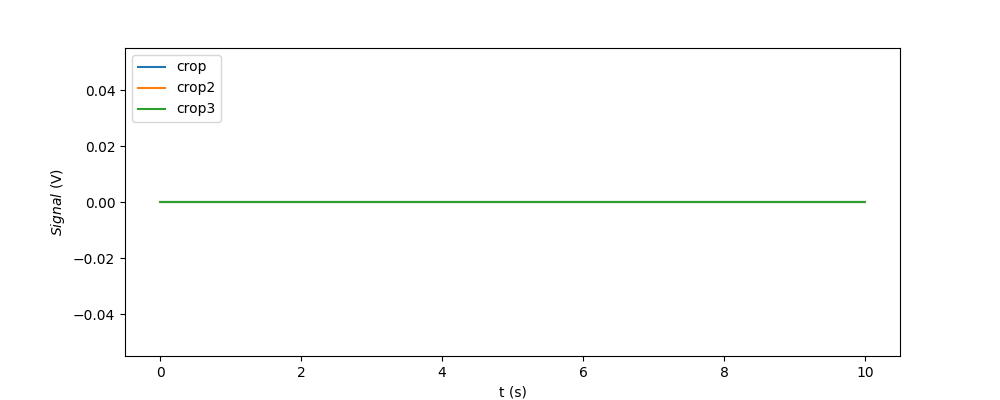

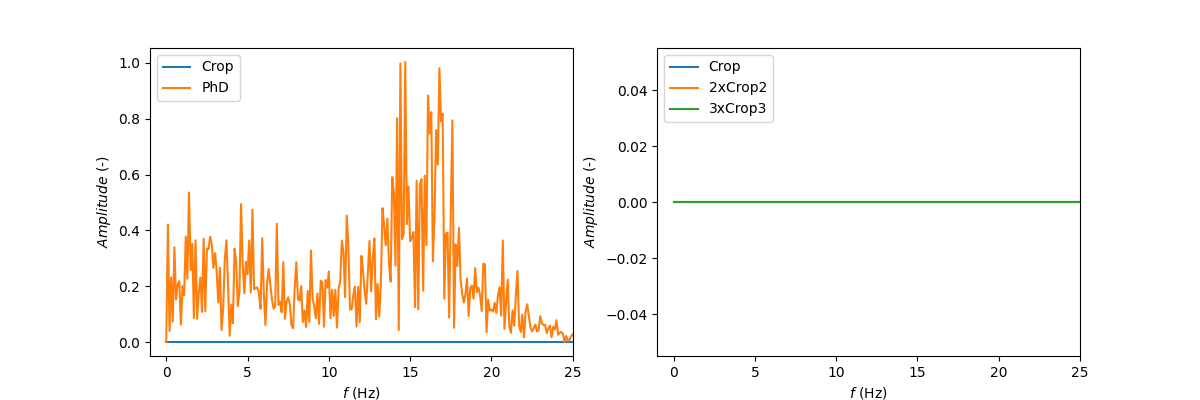

In [45]:
FFT_img = np.zeros(int(Ls/2+1))
int_flame = int_flame - np.mean(int_flame)
FFT_img = abs(np.fft.rfft(int_flame)) / Ls
freq_img = np.linspace(0,Fs_img/2,len(FFT_img))

FFT_crop = np.zeros(int(Ls/2+1))
int_crop = int_crop - np.mean(int_crop)
FFT_crop = abs(np.fft.rfft(int_crop)) / Ls

FFT_crop2 = np.zeros(int(Ls/2+1))
int_crop2 = int_crop2 - np.mean(int_crop2)
FFT_crop2 = abs(np.fft.rfft(int_crop2)) / Ls

FFT_crop3 = np.zeros(int(Ls/2+1))
int_crop3 = int_crop3 - np.mean(int_crop3)
FFT_crop3 = abs(np.fft.rfft(int_crop3)) / Ls

## figures
fig, (ax1) = plt.subplots(1,1, figsize=(10,4))      
#ax1.plot(tii,int_flame, label='Basler' + str(ii))
ax1.plot(tii,int_crop, label='crop')
ax1.plot(tii,int_crop2, label='crop2')
ax1.plot(tii,int_crop3, label='crop3')
ax1.legend(loc='upper left')
#ax1.set_title(str(lamb[0])+'nm')
ax1.set_xlabel('t (s)')
ax1.set_ylabel('$Signal$ (V)')
#ax1.set_ylim(0,0.02)


fig, (ax2, ax3) = plt.subplots(1,2, figsize=(12,4))  
#ax2.plot(freq_img,FFT_img, label='Basler')
ax2.plot(freq_img,FFT_crop, label='Crop')
#ax2.plot(freq_img,FFT_crop2, label='Crop2')
ax2.plot(freq,FFT_s[:,8], label='PhD')
ax2.legend(loc='upper left')
#ax1.set_title(str(lamb[0])+'nm')
ax2.set_xlabel('$f$ (Hz)')
ax2.set_ylabel('$Amplitude$ (-)')
ax2.set_xlim(-1,25)
#ax2.set_ylim(0,1)

#ax2.plot(freq_img,FFT_img, label='Basler')
ax3.plot(freq_img,FFT_crop, label='Crop')
ax3.plot(freq_img,FFT_crop2*2, label='2xCrop2')
ax3.plot(freq_img,FFT_crop3*3, label='3xCrop3')
#ax2.plot(freq,FFT_s[:,8], label='PhD')
ax3.legend(loc='upper left')
#ax1.set_title(str(lamb[0])+'nm')
ax3.set_xlabel('$f$ (Hz)')
ax3.set_ylabel('$Amplitude$ (-)')
ax3.set_xlim(-1,25)
#ax2.set_ylim(0,1)